In [1]:
%load_ext autoreload
%autoreload 2

import particle as pt
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mplhep
from scipy.stats import norm
from scipy.optimize import curve_fit
import matplotlib.mlab as mlab
import time
from matplotlib.colors import LogNorm
mplhep.style.use(mplhep.style.ROOT)
from pprint import pprint
from tqdm import tqdm
import polars as pl
import sys
import os
import particle
# using getlogin() returning username
user_name = os.getlogin()

sys.path.append(f'/home/{user_name}/Documents/Atmos_Pandora/apc_atmo_repo/Anatree/')
from anatree_class import Anatree
from  ana_tools import *


plt.rcParams.update({'font.size': 23,
                     'grid.linestyle': '--',
                     'axes.grid': True,
                     'figure.autolayout': True,
                     'figure.figsize': [14,6]
                     })

anatree:Anatree
mcstree:uproot.TTree
mcsangle:pl.DataFrame
dfana:pl.DataFrame

In [2]:
data_path = "/home/henrique/Documents/Atmos_Pandora/data/ereco2/"
anatree = Anatree(f'{data_path}/original.root', load_data=False)
anatree.tree:uproot.TTree

In [87]:
anatree.read_parquet(f'{data_path}/parquet_original')
dfana = anatree.nu.collect()

Reading nu files... 15/15

Reading reco_tracks files... 15/15




In [346]:
def select_numu_cc(df:pl.DataFrame, checkContained = True, isCointained=0):
    df = df.filter(
        (pl.col('nuPDG_truth').abs() == 14) & (pl.col('ccnc_truth')==0)
    )
    if checkContained:
        df = df.filter(
            (pl.col('LongestTrackContNumu')==isCointained)
        )
        
    df = df.with_columns(
        E = (pl.col('lep_mom_truth')**2 + 0.1057**2).sqrt(),
        Echi2 = pl.when(pl.col("RecoLepEnNumu_mcs_chi2")>0).then(pl.col("RecoLepEnNumu_mcs_chi2")).otherwise(0.1),
        Ellhd = pl.when(pl.col("RecoLepEnNumu_mcs_llhd")>0).then(pl.col("RecoLepEnNumu_mcs_llhd")).otherwise(0.1),
    )
    return df
def get_dump(fname):

    mcstree = uproot.open(fname)
    arr={}
    for c in mcstree.keys():
        a  = mcstree[c].array()
        arr[c] = a

    tangles = pd.DataFrame(arr)
    return pl.from_pandas(tangles)

mcsangle = get_dump(f'{data_path}/llhd_dump.root:t1')
dfana = select_numu_cc(dfana)
mcsangle = mcsangle.rename({"p":"E"})
mcsangle = mcsangle.with_columns(
    p = (pl.col("E")**2 - 0.1057**2).sqrt()
)

In [155]:
mcsangle = mcsangle.with_columns(
    Ei = pl.col("E") - pl.col("ei")
).sort(selection_events())
mcsangle




subrun,event,azx,azy,ei,ej,E,len,p,Ei
i32,i32,f64,f64,f64,f64,f64,f64,f64,f64
0,4,23.983662,-2.065578,0.0,0.021,1.715077,110.193135,1.711817,1.715077
0,4,24.34717,7.930338,0.021,0.042,1.715077,110.193135,1.711817,1.694077
0,4,20.164886,24.140313,0.042,0.063,1.715077,110.193135,1.711817,1.673077
0,4,32.796548,30.795224,0.063,0.084,1.715077,110.193135,1.711817,1.652077
0,4,31.152052,25.762731,0.084,0.105,1.715077,110.193135,1.711817,1.631077
0,4,8.458911,17.795028,0.105,0.126,1.715077,110.193135,1.711817,1.610077
0,4,-0.892046,6.416167,0.126,0.147,1.715077,110.193135,1.711817,1.589077
0,4,6.255492,-2.351429,0.147,0.168,1.715077,110.193135,1.711817,1.568077
0,4,56.761928,13.468452,0.168,0.189,1.715077,110.193135,1.711817,1.547077


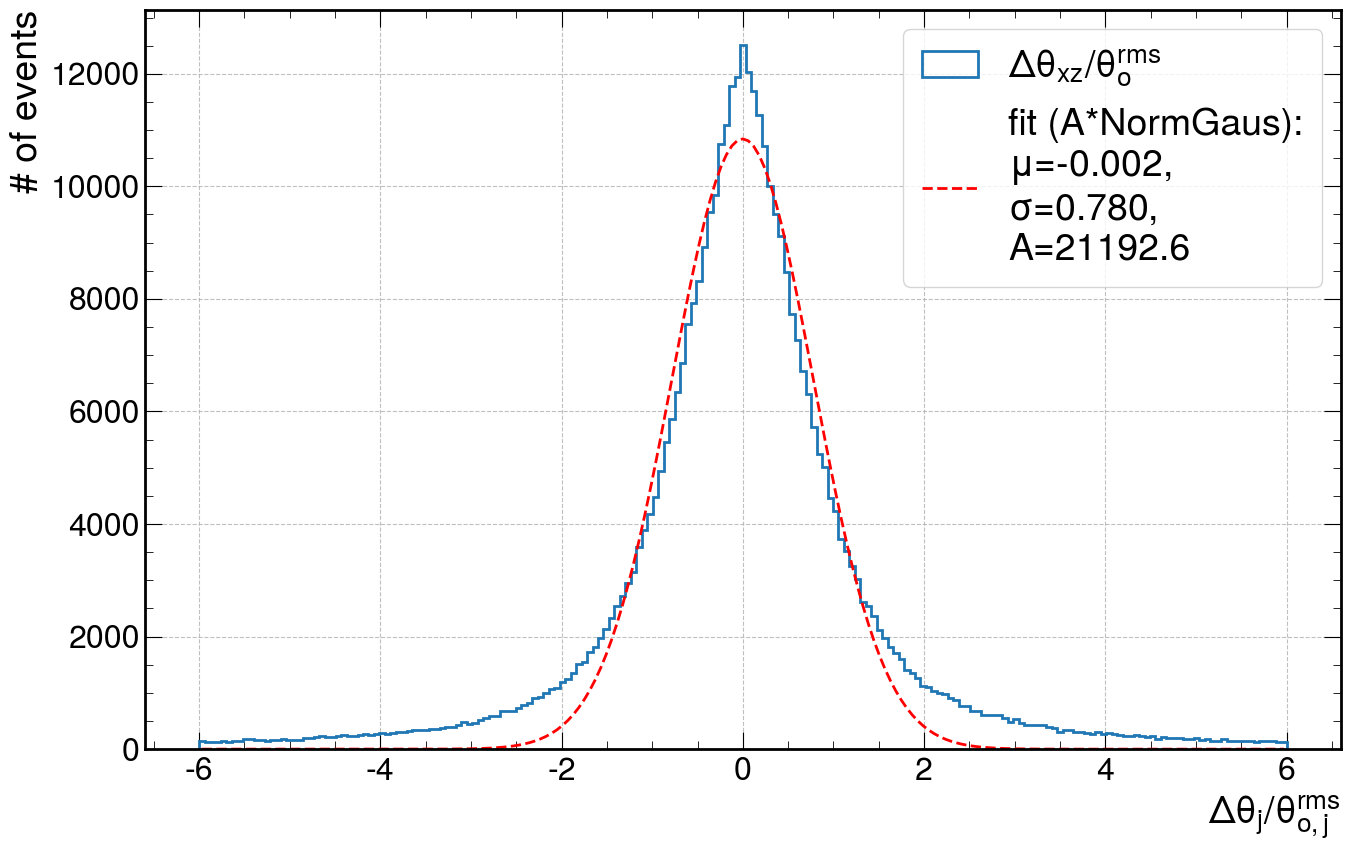

In [491]:
def compute_rms(p=None, _ei=None):
    if p is None: 
        p = pl.col('p')
    if _ei is None: 
        _ei = pl.col('ei')


    
    
    a = 0.1049
    c = 11.0038

    rad_length = 14.0
    stepsize = 10
    red_length = stepsize / rad_length
    m_muon = 0.1057
    nonrel_Etot = np.sqrt(p*p + m_muon*m_muon)
    # nonrel_Eij = pl.col("Ei")
    nonrel_Eij = nonrel_Etot - _ei

    nonrel_pij = np.sqrt(nonrel_Eij*nonrel_Eij - m_muon*m_muon)
    beta = np.sqrt(1 - ((m_muon*m_muon)/(nonrel_pij*nonrel_pij + m_muon*m_muon)))
    tH0 = ( (a/p**2 + c) / (nonrel_pij*beta)) * (1.0 + 0.038 * np.log(red_length/beta**2)) * np.sqrt(red_length)
    return tH0

dfana_filter = dfana.select(selection_events())
mcsangle = mcsangle.join(dfana_filter, on=selection_events(), how='inner')
mcsangle = mcsangle.with_columns(
    rms = ( compute_rms()**2 + 2**2 ).sqrt(),
    theta = (pl.col('azx')**2 + pl.col('azy')**2).sqrt(),
    seg = (pl.col('ej')/0.0021)
    # theta = (1./(1.+pl.col('azx').tan()**2+pl.col('azy').tan()**2).sqrt()).arccos()#*pl.col('azx').sign()
    # theta = ((pl.col('azx')/1000).cos()*(pl.col('azy')/1000).cos()).arccos()*1000*(pl.col('azx')/1000).cos().sign()
)
from scipy.optimize import curve_fit
def gaus(x, u, s, a):
    return (a/np.sqrt(2*np.pi*s*s))*np.exp(-((x-u)/s)**2/2)

df = mcsangle
dfplot = df#.filter(pl.col("E")<1)#.filter((pl.col('azx')/pl.col('rms')).abs()>0.0007)
dfplot = df.filter((pl.col('azx')).abs()>0.01)
plt.figure(figsize=(14,9))
binsx = np.linspace(-6,6,200)
# heigths, hedges, _ = plt.hist((dfplot['azy']/dfplot['rms'])*np.sqrt(2), bins=binsx, histtype='step', label=r'$\sqrt{2} \times \Delta\theta_{xz}/\theta^{rms}_o$',lw=2,color='k');
heigths, hedges, _ = plt.hist((dfplot['azy']/dfplot['rms']), bins=binsx, histtype='step', label=r'$\Delta\theta_{xz}/\theta^{rms}_o$',lw=2);
hcenters = (hedges[1:] + hedges[:-1])*0.5
popt, pcov = curve_fit(gaus, hcenters, heigths, p0=[0,1,35000])
# popt[1] = popt[1]/np.sqrt(2)
plt.plot(hcenters, gaus(hcenters, *popt), 'r--', label="fit (A*NormGaus):\n" r"$\mu$=%5.3f," "\n" r"$\sigma$=%5.3f," "\n" "A=%5.1f" % tuple(popt), lw=2)
plt.tick_params(labelsize=23)
plt.xlabel(r'$\Delta\theta_j/\theta^{rms}_{o, j}$', fontsize=27)
plt.ylabel('# of events', fontsize=27)
plt.legend(frameon=True, fontsize=27)

In [449]:
# Example bad reconstruction, 70,1 is a muons escaping, llhd and range give same result
dfsmalls = dfplot.group_by(selection_events()).agg(
    azx_total = pl.count(),
    azx_small = pl.col('azx').filter((pl.col('azx')/pl.col('rms')).abs()<0.07).count(),
    len = pl.col('len') .first(),
    E = pl.col('E').first()
).with_columns(
    frac = pl.col('azx_small')/pl.col('azx_total')
).filter(pl.col("azx_small")>0)
# df
dfsmalls.describe()

describe,subrun,event,azx_total,azx_small,len,E,frac
str,f64,f64,f64,f64,f64,f64,f64
"""count""",9899.0,9899.0,9899.0,9899.0,9899.0,9899.0,9899.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",3762.927063,10.516012,39.540358,3.661885,417.301161,6.090845,0.114351
"""std""",2159.219742,5.745532,29.784263,5.782543,349.238629,10.792662,0.114812
"""min""",0.0,1.0,1.0,1.0,20.059796,0.108737,0.007407
"""25%""",1874.0,6.0,17.0,1.0,188.441995,1.038132,0.054054
"""50%""",3756.0,11.0,32.0,2.0,340.382614,2.28577,0.085106
"""75%""",5632.0,16.0,55.0,4.0,568.93345,5.801939,0.130435
"""max""",7499.0,20.0,286.0,170.0,13916.878502,98.411686,1.0


Text(0, 1, '# of events')

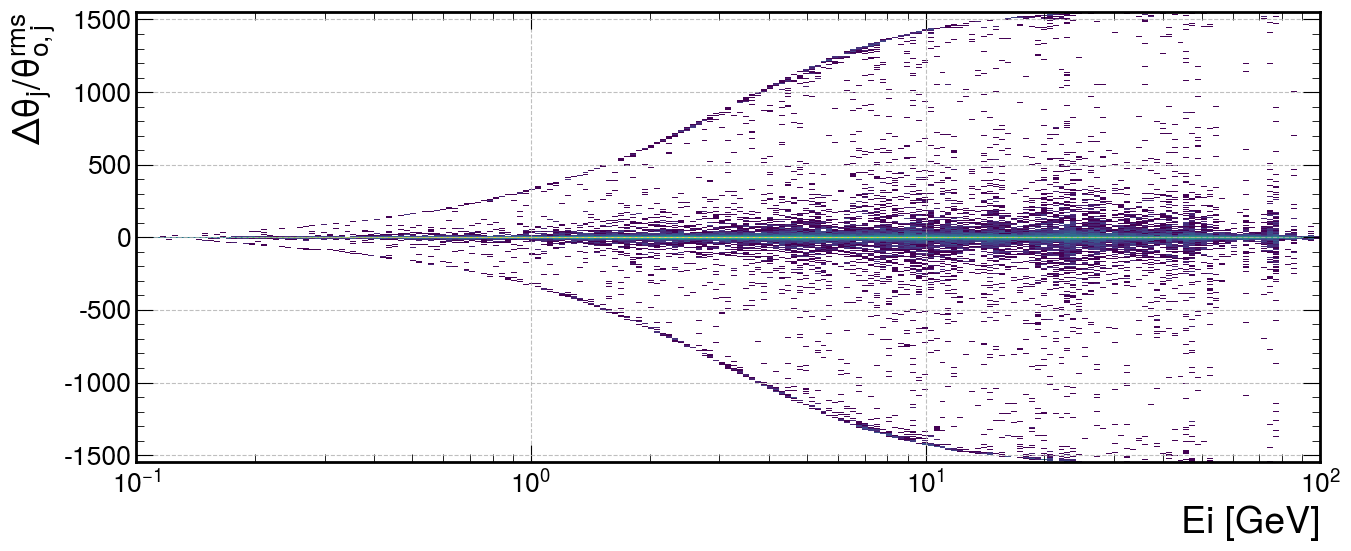

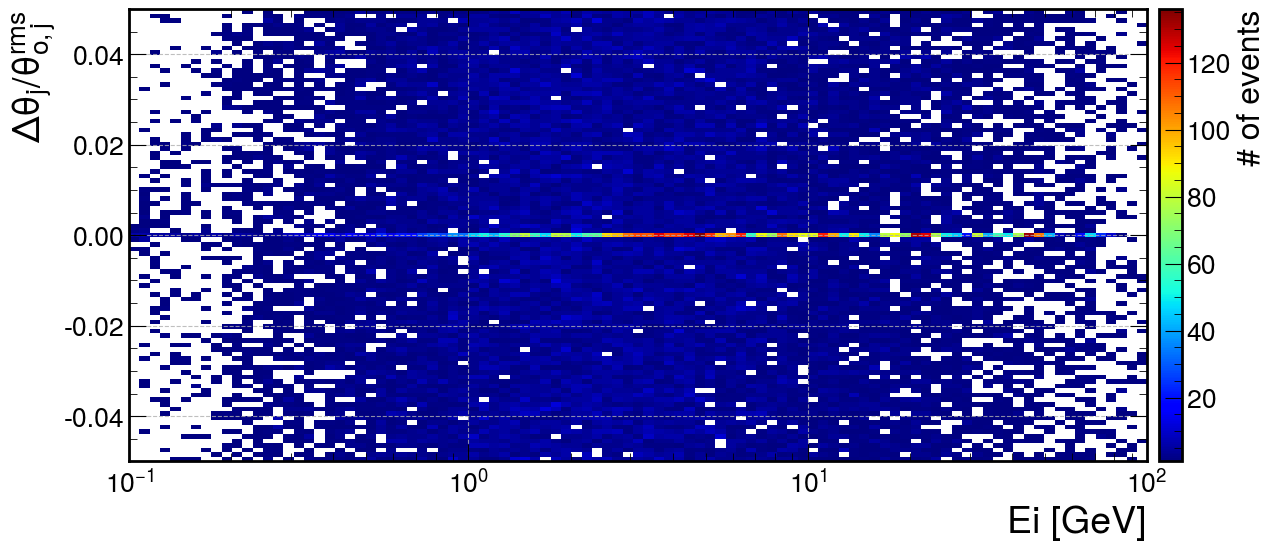

In [432]:

plt.hist2d(dfplot['Ei'], dfplot['azx']/dfplot['rms'], bins=[np.logspace(-1,2,200), np.linspace(-1550,1550,500)], norm='log', label='Some');
plt.xlabel('Ei [GeV]', fontsize=27)
plt.ylabel(r'$\Delta\theta_j/\theta^{rms}_{o, j}$', fontsize=27)
plt.xscale('log')

plt.figure()
plt.hist2d(dfplot['Ei'], dfplot['azx']/dfplot['rms'], bins=[np.logspace(-1,2,100), np.linspace(-4,4,100)], cmap=plt.cm.jet, cmin=1)
# plt.hist2d(dfplot['Ei'], dfplot['azx']/dfplot['rms'], bins=[np.logspace(-1,2,100), np.linspace(-10,10,100)], cmap=plt.cm.jet, cmin=1)
# fakeE = np.logspace(-1,2,200)
# fakeEi = np.zeros_like(fakeE)
# fakeRMS = compute_rms(fakeE, fakeEi)
# plt.plot(fakeE,fakeRMS, '--', color='red', lw=2)
plt.xlabel('Ei [GeV]', fontsize=27)
plt.ylabel(r'$\Delta\theta_j/\theta^{rms}_{o, j}$', fontsize=27)
# plt.ylabel(r'$\Delta\theta_{zx}$', fontsize=27)
plt.xscale('log')
cbar = plt.colorbar(pad=0.01)
cbar.ax.set_ylabel('# of events', fontsize=23)
# dfplot.filter(get_event(70,1))
# anatree.nu.filter(get_event(70,1))["RecoLepEnNumu_mcs_llhd"]

subrun,event,azx,azy,ei,ej,E,len,p,Ei,rms,theta,seg
i32,i32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0,9,1.001367,0.817921,0.0,0.021,4.463607,1443.608426,4.462356,4.463607,2.870479,1.292955,10.0
0,9,-3.588613,-0.893958,0.021,0.042,4.463607,1443.608426,4.462356,4.442607,2.877476,3.698284,20.0
0,9,-11.486227,-11.781581,0.042,0.063,4.463607,1443.608426,4.462356,4.421607,2.884557,16.45415,30.0
0,9,0.13563,-9.018526,0.063,0.084,4.463607,1443.608426,4.462356,4.400607,2.891722,9.019546,40.0
0,9,7.483243,5.622367,0.084,0.105,4.463607,1443.608426,4.462356,4.379607,2.898972,9.360017,50.0
0,9,0.67579,4.275347,0.105,0.126,4.463607,1443.608426,4.462356,4.358607,2.906308,4.328428,60.0
0,9,0.676987,0.116402,0.126,0.147,4.463607,1443.608426,4.462356,4.337607,2.913733,0.686921,70.0
0,9,3.909469,0.110567,0.147,0.168,4.463607,1443.608426,4.462356,4.316607,2.921248,3.911032,80.0
0,9,0.405686,-2.772729,0.168,0.189,4.463607,1443.608426,4.462356,4.295607,2.928853,2.802251,90.0


In [229]:
# pl.Config.set_tbl_rows(40)
# dfout.group_by(selection_events()).agg(
#     pl.count(),
#     pl.all(),
# ).explode(pl.all().exclude(selection_events(['count']))).sort('subrun').sort('count', descending=True).head(40)

dfllhd = df.group_by(selection_events()).agg(
    pl.all().exclude('seg','len','p'),
    seg = pl.col('seg').first(),
    len = pl.col('len').first(),
    p = pl.col('p').first(),
)
vals = dfllhd.select(['theta', 'ei', 'ej', 'p', 'subrun', 'event', 'azx', 'azy','len']).to_numpy()
thetas = vals[:,0]
ei = vals[:,1]
ej = vals[:,2]
trueP = vals[:,3]
srun = vals[:,4]
evt = vals[:,5]
azx = vals[:,6]
azy = vals[:,7]
trklen = vals[:,8]


    

In [475]:
import numba as nb
ignoresmall = False
@nb.njit
def llhd(evDT, evEi, p, res, ignoresmall):
    a = 0.1049
    c = 11.0038


    rad_length = 14.0
    stepsize = 10
    red_length = stepsize / rad_length
    m_muon = 0.1057
    nonrel_Etot = np.sqrt(p*p + m_muon*m_muon)

    result = 0
    for idx in nb.prange(len(evDT)):
        dth = evDT[idx]
        dei = evEi[idx]
        nonrel_Eij = nonrel_Etot - dei
        # if nonrel_Eij < m_muon:
        #     return 99999

        nonrel_pij = np.sqrt(nonrel_Eij*nonrel_Eij - m_muon*m_muon)
        # if nonrel_Eij*nonrel_Eij - m_muon*m_muon < 0:
        #     print(nonrel_Eij, m_muon, nonrel_Etot, p, dei, Ei)
        beta = np.sqrt(1 - ((m_muon*m_muon)/(nonrel_pij*nonrel_pij + m_muon*m_muon)))
        tH0 = ( (a/nonrel_pij**2 + c) / (nonrel_pij*beta)) * (1.0 + 0.038 * np.log(red_length/beta**2)) * np.sqrt(red_length)

        rms = (tH0**2 + res**2)
        if ignoresmall and dth < 0.07:
            continue
        prob = -0.5*np.log(2*np.pi) - 0.5*np.log(rms) - 0.5*dth*dth/rms
        result-=2*prob
    return result
def call_llhd(p:float, res:float, ev:int):
    global DT
    global Ei
    global ignoresmall 
    
    ev = int(ev)
    result = 0
    result = llhd(DT[ev], Ei[ev], p, res, ignoresmall)
    return result


idx: 4, subrun: 13, event: 1, p = 1.20


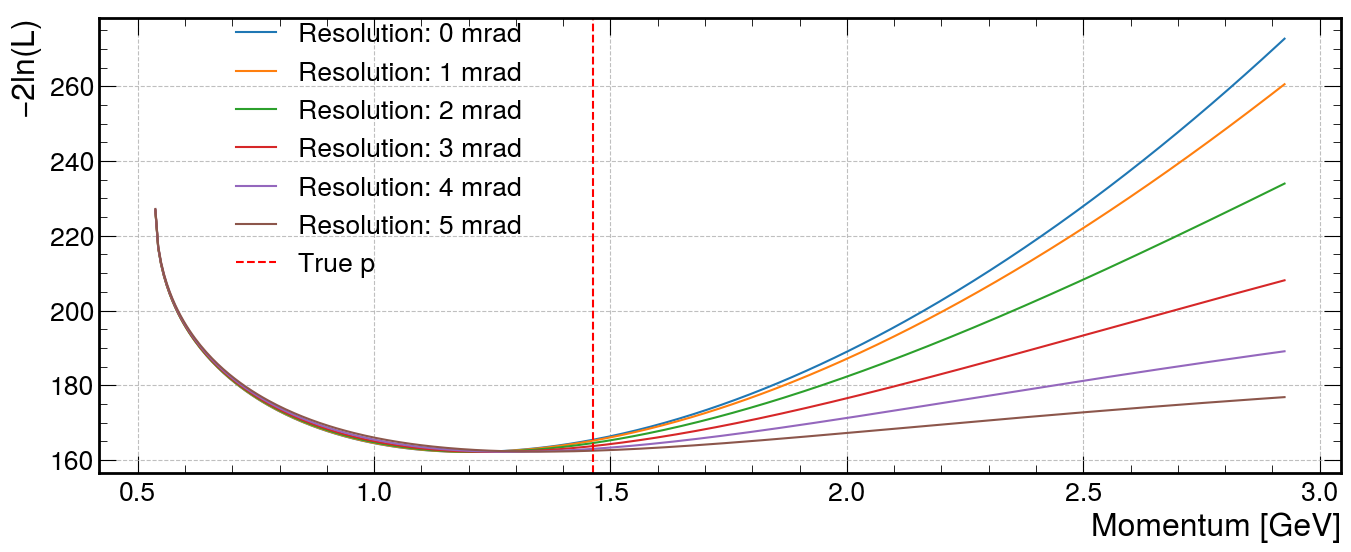

In [476]:
res_scan = [ r for r in range(0,6,1)]
res = [[] for _ in res_scan]
ptry = [[] for _ in res]
idx=4
DT = thetas#[idx]/np.sqrt(2)
# DT = azy[idx]
global ei
Ei = ei#[idx]
for r,i in enumerate(res_scan):
    for x in np.linspace(np.sqrt(Ei[idx][-1]*(2*0.1057+Ei[idx][-1])) + 0.001, 2*trueP[idx], 400):
        ll = call_llhd(x, r, idx)
        res[i].append(ll)
        ptry[i].append(x)
    plt.plot(ptry[i], res[i], label=f"Resolution: {r:.0f} mrad")
# plt.yscale('log')
plt.axvline(trueP[idx], color='r', linestyle='--', label='True p')
plt.ylabel(r'$-2ln(\mathcal{L})$')
plt.xlabel('Momentum [GeV]')
axbox = plt.gca().get_position
plt.legend(loc=(0.1,0.4),ncol=1)
print(f'idx: {idx}, subrun: {srun[idx]}, event: {evt[idx]}, p = {ptry[0][np.argmin(res[0])]:.2f}')

In [477]:
from iminuit import Minuit, cost
from iminuit.util import describe


def lazy_min(start=0, maxevt=-1, deltatheta = None, resval = 0, fixres = True, limitres=(0,100)):
    global trueP
    global Ei
    global DT
    
    DT =deltatheta
    Ei = ei
    indexes = [ i for i, _ in enumerate(trueP)]

    if maxevt != -1:
        p_ = trueP[start:maxevt]
        indexes = indexes[start:maxevt]
    else:
        p_ = trueP[start:]
        indexes = indexes[start:]
    
    trueE = np.zeros_like(p_)
    recoE = np.zeros_like(p_)
    fitS = np.zeros_like(p_)
    for idx, ev in enumerate(tqdm(indexes)):
        pt = p_[idx]
        pars = ['p', 'res', 'ev']
        minP = np.sqrt(Ei[ev][-1]*(2*0.1057+Ei[ev][-1])) + 0.001
        initalP = 1
        if initalP < minP: initalP=minP
        m = Minuit(call_llhd, p=initalP, res=resval, ev=ev)
        m.tol = 0.01/2.
        m.fixed['ev'] = True
        m.limits['p']=(minP,100)
        m.limits['res']=(0,100)
        m.fixed['res'] = fixres
        m.migrad()
        vals = [m.values[par] for par in pars]
        trueE[idx] = np.sqrt(pt**2 + 0.1057**2)
        recoE[idx] = np.sqrt(vals[0]**2 + 0.1057**2)
        fitS[idx] = m.fmin.is_valid
    trueE = trueE.astype(float)
    recoE = recoE.astype(float)
    return trueE, recoE , fitS


In [244]:
trueE, recoE, fitS = lazy_min(0,-1, thetas/np.sqrt(2), True)

100%|██████████| 15125/15125 [00:02<00:00, 5186.55it/s]


In [245]:
trueE_nosqrt, recoE_nosqrt, fitS_nosqrt = lazy_min(0,-1, thetas, True)

100%|██████████| 15125/15125 [00:03<00:00, 4982.07it/s]


In [246]:
trueE_azx, recoE_azx, fitS_azx = lazy_min(0,-1, azx, True)

100%|██████████| 15125/15125 [00:03<00:00, 4763.04it/s]


In [247]:
trueE_azy, recoE_azy, fitS_azy = lazy_min(0,-1, azy, True)
# trueE_fitres, recoE_fitres, fitS_fitres = lazy_min(0,-1, thetas, False)

100%|██████████| 15125/15125 [00:02<00:00, 5107.03it/s]


In [248]:
trueE_at2, recoE_at2, fitS_at2 = lazy_min(0,-1, thetas/np.sqrt(2), fixres=True, resval=2)
trueE_azx_at2, recoE_azx_at2, fitS_azx_at2 = lazy_min(0,-1, azx, fixres=True, resval=2)
trueE_azx_at2_sqrt, recoE_azx_at2_sqrt, fitS_azx_at2_sqrt = lazy_min(0,-1, azx*np.sqrt(2), fixres=True, resval=2)
trueE_azx_sqrt, recoE_azx_sqrt, fitS_azx_sqrt = lazy_min(0,-1, azx*np.sqrt(2), fixres=True, resval=0)

100%|██████████| 15125/15125 [00:03<00:00, 4777.27it/s]


In [250]:
trueE_nosqrt_extra, recoE_nosqrt_extra, fitS_nosqrt_extra = lazy_min(0,-1, thetas*1.1, True)

100%|██████████| 15125/15125 [00:03<00:00, 5010.48it/s]


In [478]:
ignoresmall = True
trueE_nosqrt_skip, recoE_nosqrt_skip, fitS_nosqrt_skip = lazy_min(0,-1, thetas, True)
ignoresmall = False

  0%|          | 0/15125 [00:00<?, ?it/s]

100%|██████████| 15125/15125 [00:03<00:00, 4508.90it/s]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 1400x600 with 0 Axes>

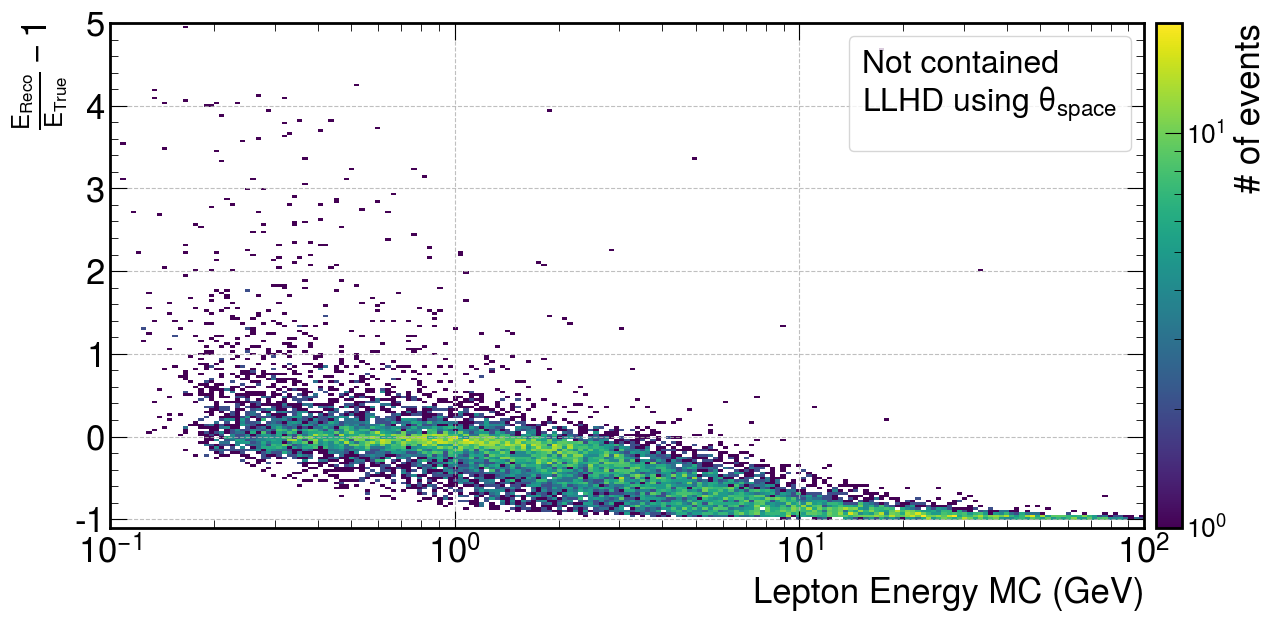

<Figure size 1400x600 with 0 Axes>

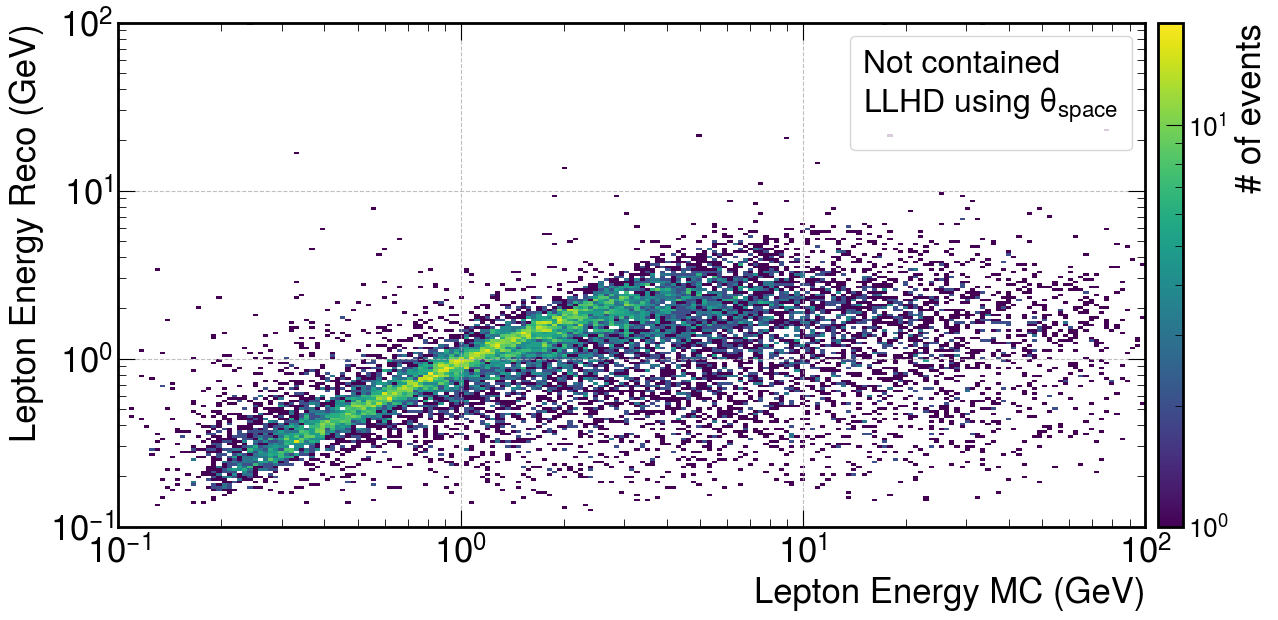

In [479]:
def display_en_reco(x,
                    y,
                    binse = np.logspace(-1,2,200),
                    binsy = np.linspace(-1.1,5,200),
                    xlabel = 'Lepton Energy MC (GeV)',
                    ylabel = r'$\frac{E_{Reco}}{E_{True}} - 1$',
                    fontsize=25,
                    lmethod='',
                    makefrac=True,
                    xscale='log',
                    yscale='linear'):
    plt.figure()
    plotx = x
    ploty = y
    plt.figure(figsize=(14,6.7))
    if makefrac:
        plt.hist2d(plotx, (ploty/plotx-1), bins=[binse,binsy], norm='log');
    else:
        plt.hist2d(plotx, ploty, bins=[binse,binsy], norm='log');
    fontsize=25
    if makefrac: plt.plot([0,100],[0,100], '--', c='r')
    plt.xscale(xscale)
    plt.yscale(yscale)
    plt.xlabel(xlabel, fontsize=fontsize)
    plt.ylabel(ylabel, fontsize=fontsize)
    plt.tick_params(labelsize=fontsize)
    cbar = plt.colorbar(pad=0.01)
    cbar.ax.set_ylabel('# of events', fontsize=fontsize)
    if lmethod:
        legend = plt.legend(frameon=True, title=lmethod, loc='upper right')
    plt.plot();
display_en_reco(trueE_nosqrt_skip,
                recoE_nosqrt_skip,
                lmethod = r"Not contained""\n"r"LLHD using $\theta_{space}$"
                )
display_en_reco(trueE_nosqrt_skip,
                recoE_nosqrt_skip,
                makefrac=False,
                ylabel='Lepton Energy Reco (GeV)',
                binsy=np.logspace(-1,2,200),
                yscale='log',
                lmethod = r"Not contained""\n"r"LLHD using $\theta_{space}$"
                )

(0.0, 200.0)

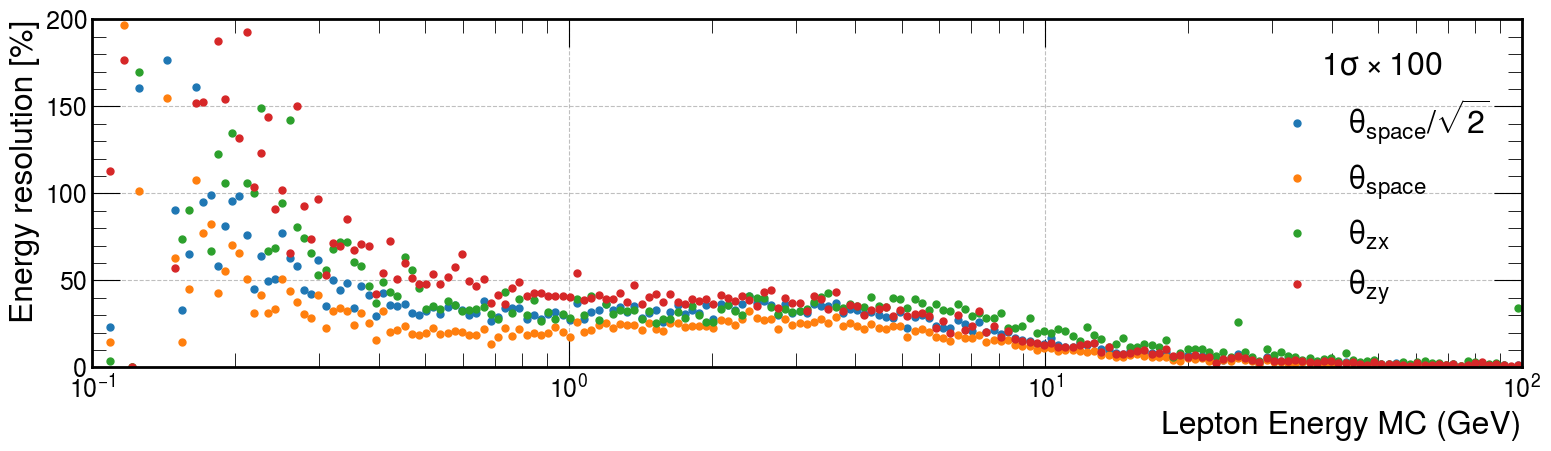

In [417]:
from scipy.stats import binned_statistic
def plot_res_vs_energy(varx, vary, actualx=None, binsx = np.logspace(-1,2,200), fmt = '.', infotype='std', **kwargs):
    vary = (vary/varx-1)
    if not actualx is None:
        varx = [v for v in actualx]
    if infotype=='std':
        val, _, _ = binned_statistic(varx, vary*100, manual_std, binsx)
        median, _, _ = binned_statistic(varx, vary, "median", binsx)
        ylabel = r'Energy resolution [%]'
        title = r'1$\sigma\times$100'
    else:
        val, _, _ = binned_statistic(varx, vary, infotype, binsx)
        ylabel = r'$\frac{E_{reco}}{E_{true}}-1$'
        title = 'MPV'
        
    bins_center = 0.5*(binsx[:-1] + binsx[1:])
    bins_width = binsx[1:]- binsx[:-1]
    ax:plt.Axes
    ax = plt.gca()
    ax.plot(bins_center, val, fmt, markersize=10, **kwargs)
    ax.tick_params(which='both',labelsize=18)
    ax.tick_params(which='major',size=20)
    ax.tick_params(which='minor',size=10)
    plt.ylabel(ylabel, fontsize=23)
    ax.set_xscale('log')
    # plt.axhline(20,ls='--',c='gray')
    legend = plt.legend(title=title,fontsize=23)
    plt.xlim(binsx[0],binsx[-1])
    plt.sca(ax)
    
plt.figure(figsize=[16,5])
plot_res_vs_energy(trueE,
                  recoE,
                  label=r'$\theta_{space}/\sqrt{2}$')
plot_res_vs_energy(trueE_nosqrt,
                  recoE_nosqrt,
                  label=r'$\theta_{space}$')
plot_res_vs_energy(trueE_azx,
                  recoE_azx,
                  label=r'$\theta_{zx}$')
plot_res_vs_energy(trueE_azy,
                  recoE_azy,
                  label=r'$\theta_{zy}$')
plt.xlabel('Lepton Energy MC (GeV)', fontsize=23)
plt.ylim(0,200)
# plt.yscale('log')
# plt.savefig("angular_reco_geant.png", format='png', bbox_inches="tight", dpi=200)

(-1.0, 2.0)

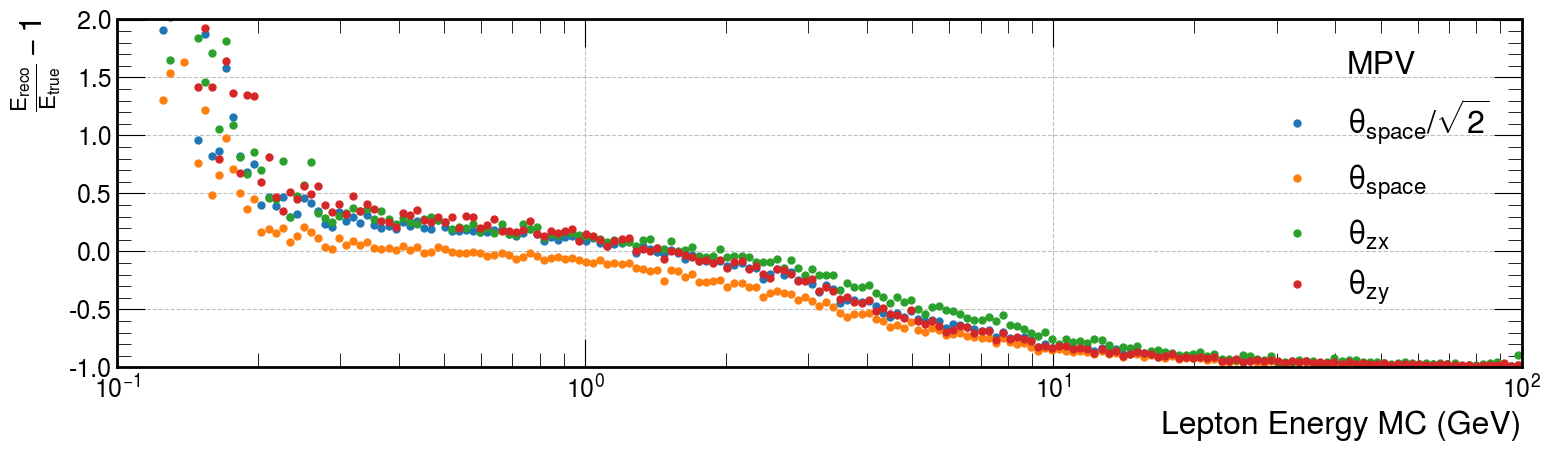

In [419]:
plt.figure(figsize=[16,5])
plot_res_vs_energy(trueE,
                   recoE,
                   infotype='median',
                   label=r'$\theta_{space}/\sqrt{2}$')
plot_res_vs_energy(trueE_nosqrt,
                   recoE_nosqrt,
                   infotype='median',
                   label=r'$\theta_{space}$')
plot_res_vs_energy(trueE_azx,
                   recoE_azx,
                   infotype='median',
                   label=r'$\theta_{zx}$')
plot_res_vs_energy(trueE_azy,
                   recoE_azy,
                   infotype='median',
                   label=r'$\theta_{zy}$')
# plot_median_vs_energy(trueE_zeroR, recoE_zeroR,  markersize=10, label=r'$\theta_{space}$, res = 2 mrad')
plt.xlabel('Lepton Energy MC (GeV)', fontsize=23)

plt.ylim(-1,2)
# plt.yscale('log')

(0.0, 200.0)

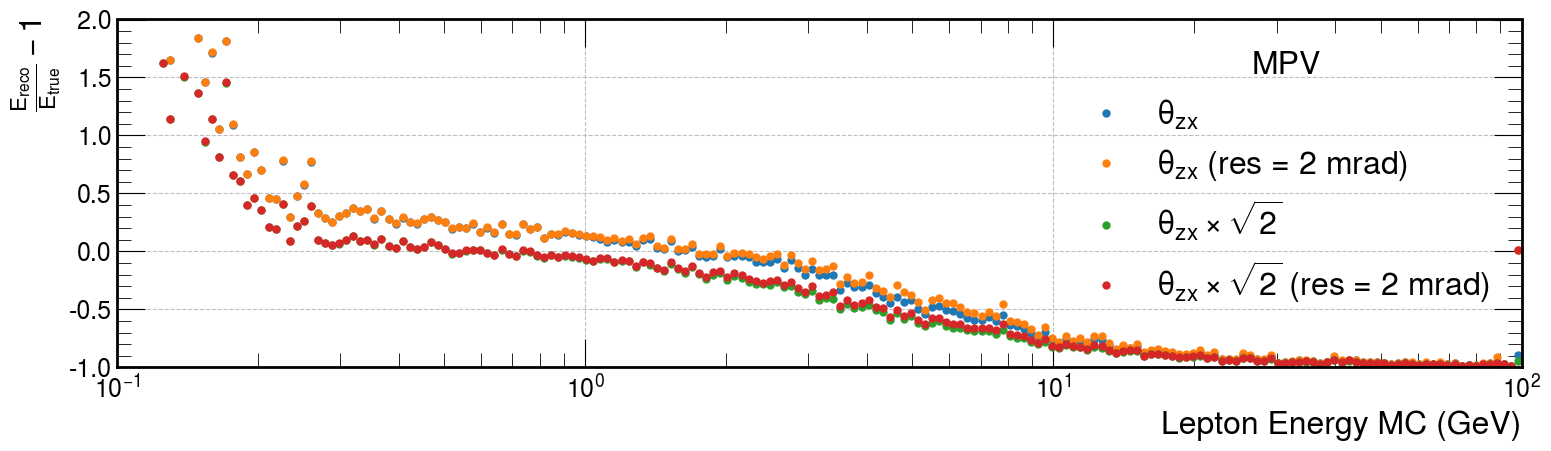

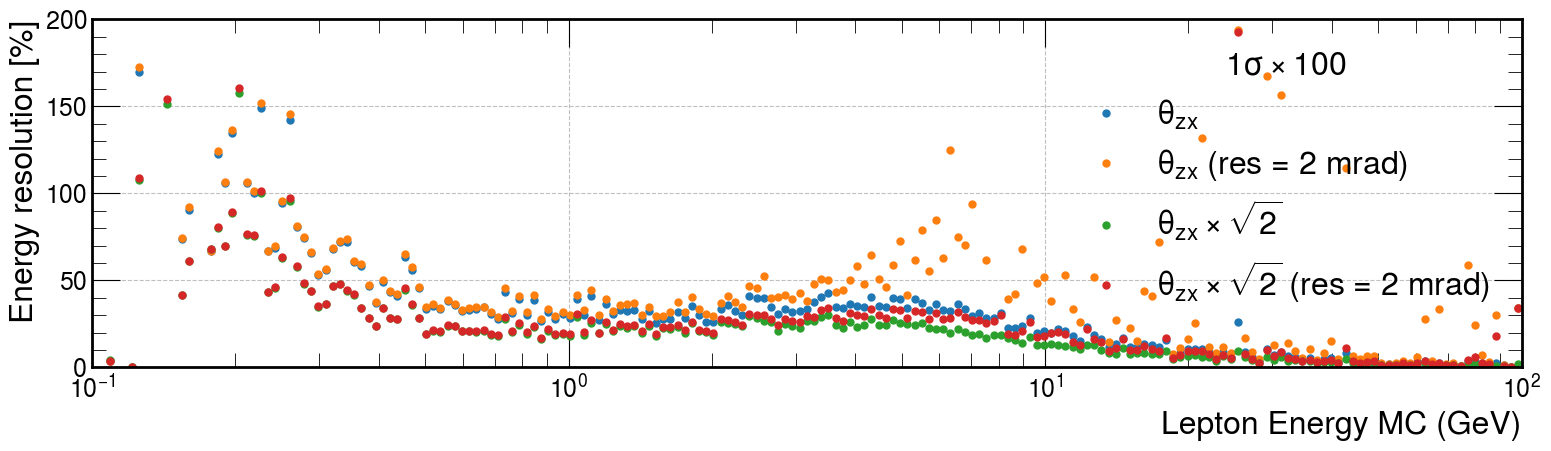

In [420]:
plt.figure(figsize=[16,5])
plot_res_vs_energy(trueE_azx,
                   recoE_azx,
                   infotype='median',
                   label=r'$\theta_{zx}$')
plot_res_vs_energy(trueE_azx_at2,
                   recoE_azx_at2,
                   infotype='median',
                   label=r'$\theta_{zx}$ (res = 2 mrad)')
plot_res_vs_energy(trueE_azx_sqrt,
                   recoE_azx_sqrt,
                   infotype='median',
                   label=r'$\theta_{zx}\times\sqrt{2}$')
plot_res_vs_energy(trueE_azx_at2_sqrt,
                   recoE_azx_at2_sqrt,
                   infotype='median',
                   label=r'$\theta_{zx}\times\sqrt{2}$ (res = 2 mrad)')
plt.xlabel('Lepton Energy MC (GeV)', fontsize=23)
plt.ylim(-1,2)

plt.figure(figsize=[16,5])
plot_res_vs_energy(trueE_azx,
                   recoE_azx,
                   label=r'$\theta_{zx}$')
plot_res_vs_energy(trueE_azx_at2,
                   recoE_azx_at2,
                   label=r'$\theta_{zx}$ (res = 2 mrad)')
plot_res_vs_energy(trueE_azx_sqrt,
                   recoE_azx_sqrt,
                   label=r'$\theta_{zx}\times\sqrt{2}$')
plot_res_vs_energy(trueE_azx_at2_sqrt,
                   recoE_azx_at2_sqrt,
                   label=r'$\theta_{zx}\times\sqrt{2}$ (res = 2 mrad)')
# plot_median_vs_energy(trueE_zeroR, recoE_zeroR,  markersize=10, label=r'$\theta_{space}$, res = 2 mrad')
plt.xlabel('Lepton Energy MC (GeV)', fontsize=23)
plt.ylim(0,200)


Reading nu files... 15/15

Reading reco_tracks files... 15/15




(0.0, 200.0)

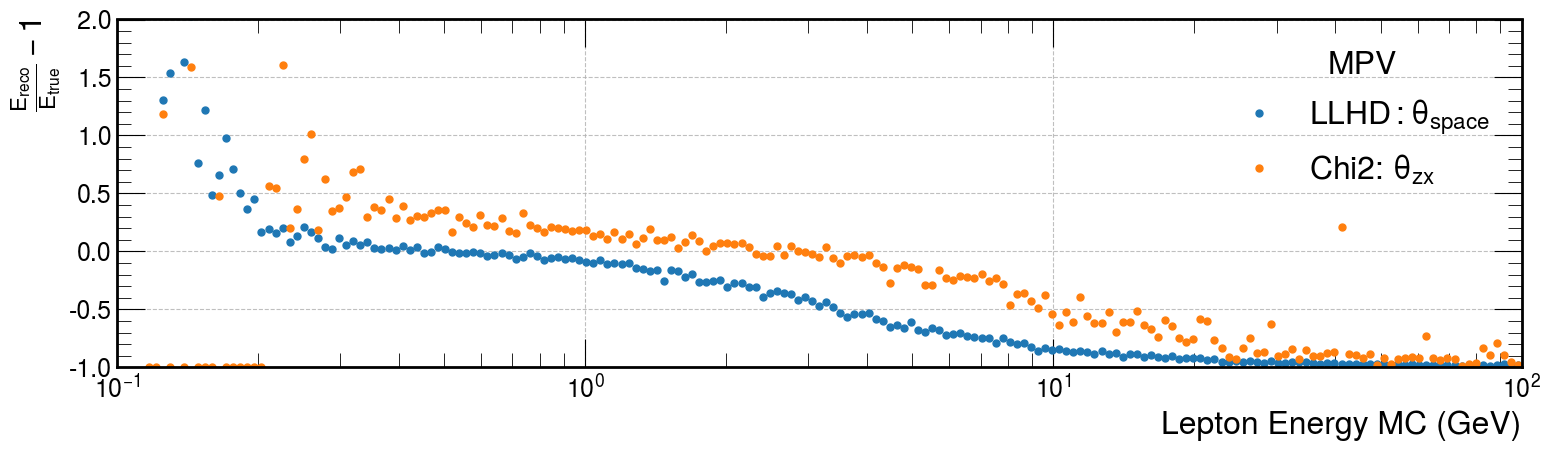

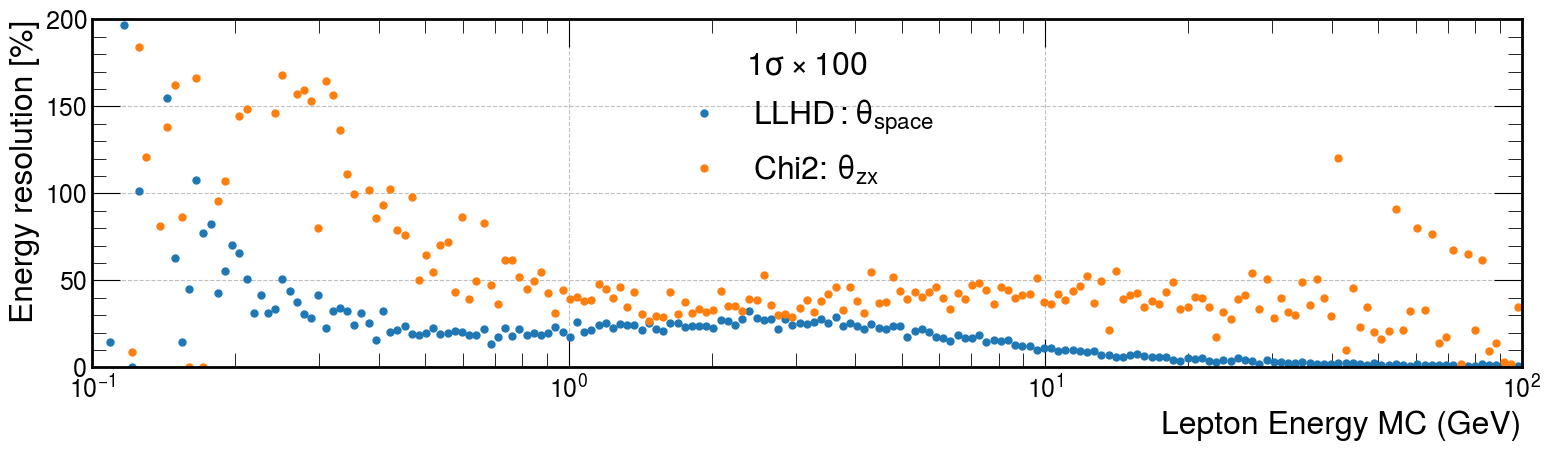

In [427]:
anatree_temp = Anatree(f'{data_path}/parquet_original_trklen_lower', load_data=False)
anatree_temp.read_parquet(f'{data_path}/parquet_original_trklen_lower')

dftemp = select_numu_cc(anatree_temp.nu.collect())
dftrack = anatree_temp.reco_tracks.collect().select(selection_events('trklen_pandoraTrack'))
dftemp = dftemp.join(dftrack, on=selection_events(), how='inner')
dftemp = dftemp.with_columns(
    Ereco = pl.col('RecoLepEnNumu_mcs_chi2')
)

plt.figure(figsize=[16,5])
plot_res_vs_energy(trueE_nosqrt,
                   recoE_nosqrt,
                   infotype='median',
                   label=r'$LLHD: \theta_{space}$')

plot_res_vs_energy(dftemp['E'],
                   dftemp['Ereco'],
                   infotype='median',
                   label=r'Chi2: $\theta_{zx}$')
plt.xlabel('Lepton Energy MC (GeV)', fontsize=23)
plt.ylim(-1,2)
plt.figure(figsize=[16,5])
plot_res_vs_energy(trueE_nosqrt,
                   recoE_nosqrt,
                   label=r'$LLHD: \theta_{space}$')

plot_res_vs_energy(dftemp['E'],
                   dftemp['Ereco'],
                   label=r'Chi2: $\theta_{zx}$')
plt.xlabel('Lepton Energy MC (GeV)', fontsize=23)
plt.ylim(0,200)

(0.0, 200.0)

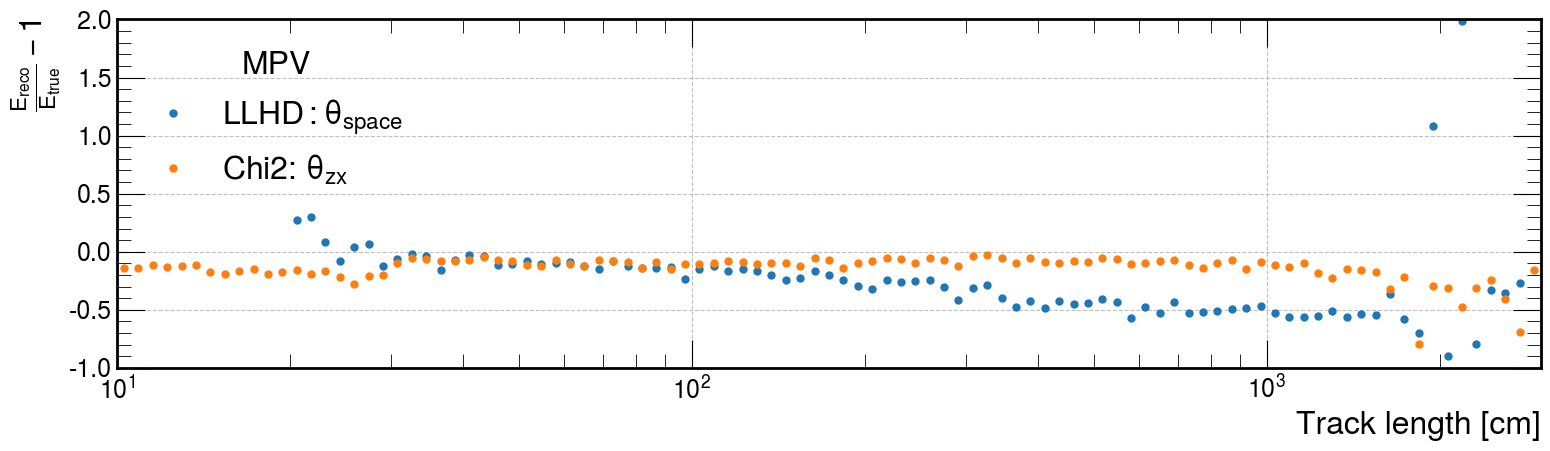

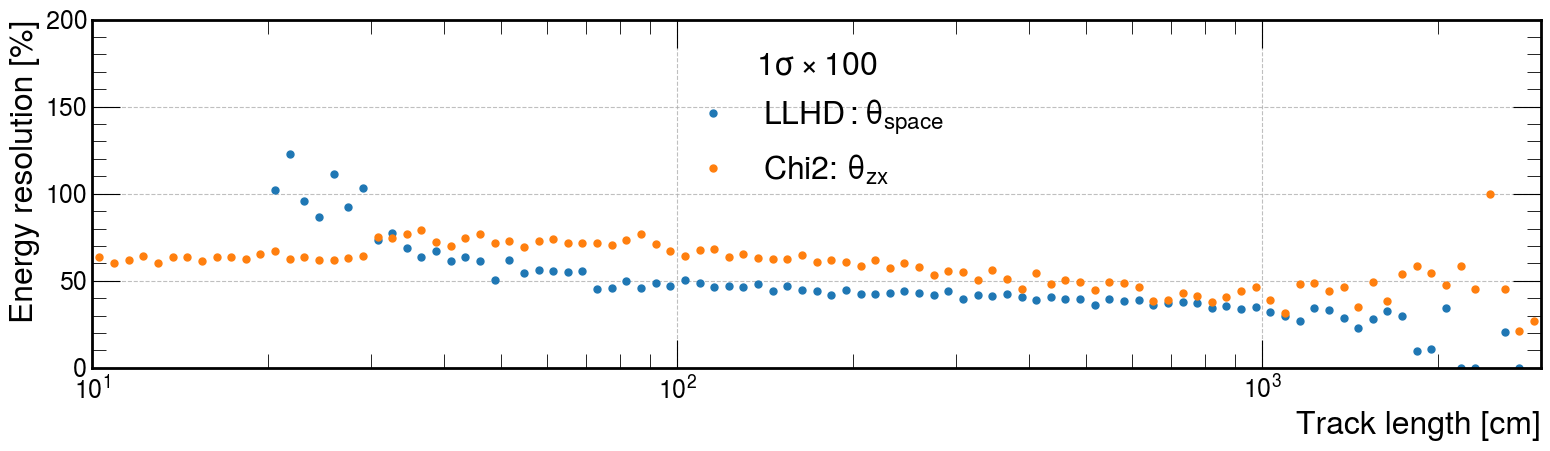

In [429]:
plt.figure(figsize=[16,5])
plot_res_vs_energy(trueE_nosqrt,
                   recoE_nosqrt,
                   actualx=trklen,
                   binsx=np.logspace(1,np.log10(3000),100),
                   infotype='median',
                   label=r'$LLHD: \theta_{space}$')

plot_res_vs_energy(dftemp['E'],
                   dftemp['Ereco'],
                   actualx=dftemp['trklen_pandoraTrack'],
                   binsx=np.logspace(1,np.log10(3000),100),
                   infotype='median',
                   label=r'Chi2: $\theta_{zx}$')
plt.xlabel('Track length [cm]', fontsize=23)
plt.ylim(-1,2)
plt.figure(figsize=[16,5])
plot_res_vs_energy(trueE_nosqrt,
                   recoE_nosqrt,
                   actualx=trklen,
                   binsx=np.logspace(1,np.log10(3000),100),
                   label=r'$LLHD: \theta_{space}$')

plot_res_vs_energy(dftemp['E'],
                   dftemp['Ereco'],
                   actualx=dftemp['trklen_pandoraTrack'],
                   binsx=np.logspace(1,np.log10(3000),100),
                   label=r'Chi2: $\theta_{zx}$')
plt.xlabel('Track length [cm]', fontsize=23)
plt.ylim(0,200)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 1400x600 with 0 Axes>

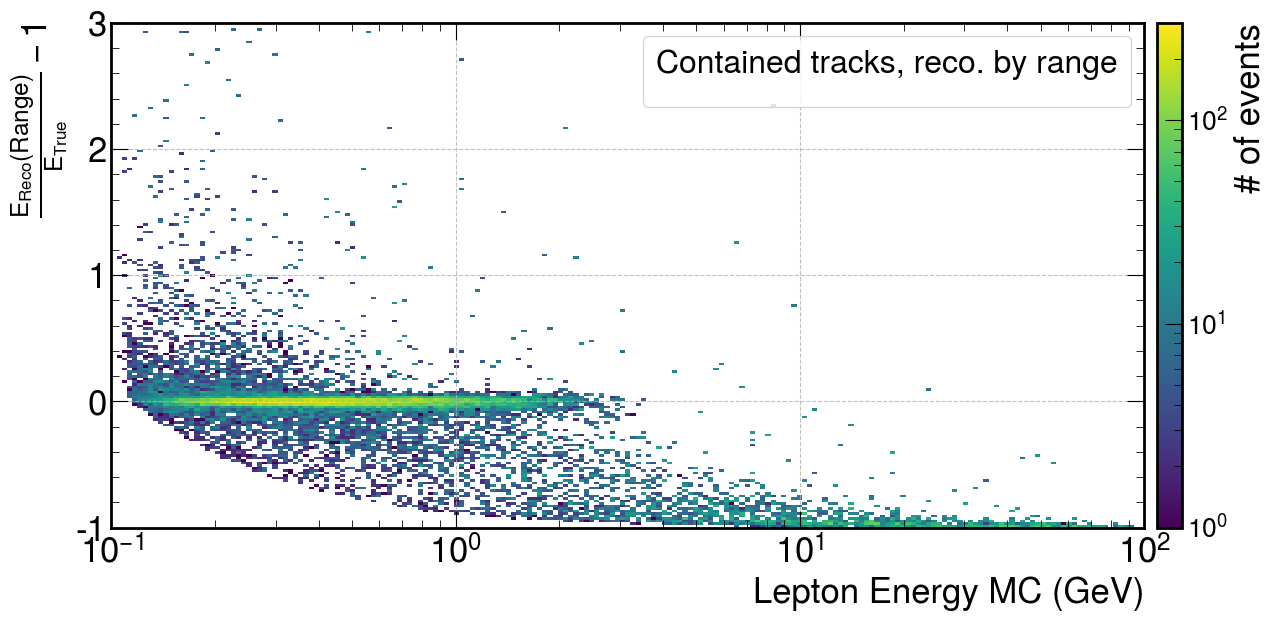

<Figure size 1400x600 with 0 Axes>

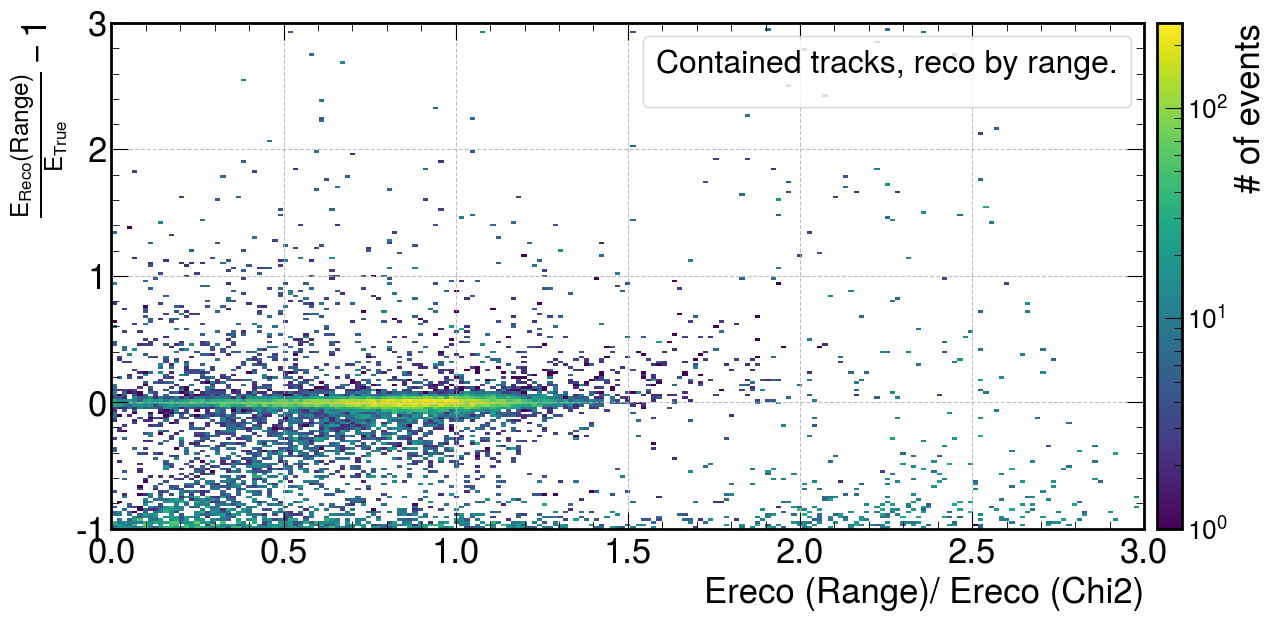

<Figure size 1400x600 with 0 Axes>

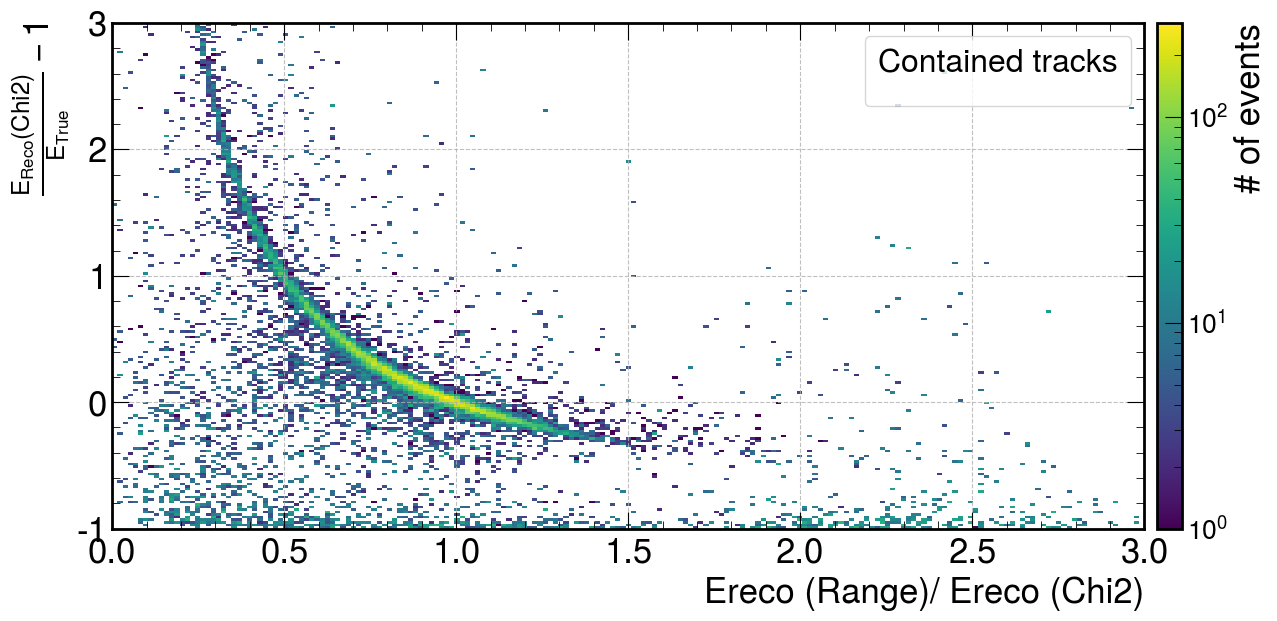

In [430]:
dfthreshold = anatree_temp.nu.collect()
dfthreshold = select_numu_cc(dfthreshold, True, 1)
dfthre= dfthreshold.join(anatree_temp.reco_tracks.collect(), on=selection_events())

display_en_reco(
    dfthre['E'],
    y = dfthre['RecoLepEnNumu_range'],
    binsy = np.linspace(-1,3,200),
    lmethod = "Contained tracks, reco. by range" ,
    ylabel=r'$\frac{E_{Reco} (Range)}{E_{True}} - 1$'
)

display_en_reco(
    x = dfthre['RecoLepEnNumu_range']/dfthre['RecoLepEnNumu_mcs_chi2'],
    y = dfthre['RecoLepEnNumu_range']/dfthre['E']-1,
    binsy = np.linspace(-1,3,200),
    binse = np.linspace(0,3,200),
    lmethod = "Contained tracks, reco by range.",
    makefrac=False,
    xscale='linear',
    xlabel=r'Ereco (Range)/ Ereco (Chi2)',
    ylabel=r'$\frac{E_{Reco} (Range)}{E_{True}} - 1$'
    # ylabel=r'Ereco (Range)/ Ereco (Chi2)',
)
display_en_reco(
    x = dfthre['RecoLepEnNumu_range']/dfthre['RecoLepEnNumu_mcs_chi2'],
    y = dfthre['RecoLepEnNumu_mcs_chi2']/dfthre['E']-1,
    binsy = np.linspace(-1,3,200),
    binse = np.linspace(0,3,200),
    lmethod = "Contained tracks",
    makefrac=False,
    xscale='linear',
    xlabel=r'Ereco (Range)/ Ereco (Chi2)',
    ylabel=r'$\frac{E_{Reco} (Chi2)}{E_{True}} - 1$'
)

(0.0, 200.0)

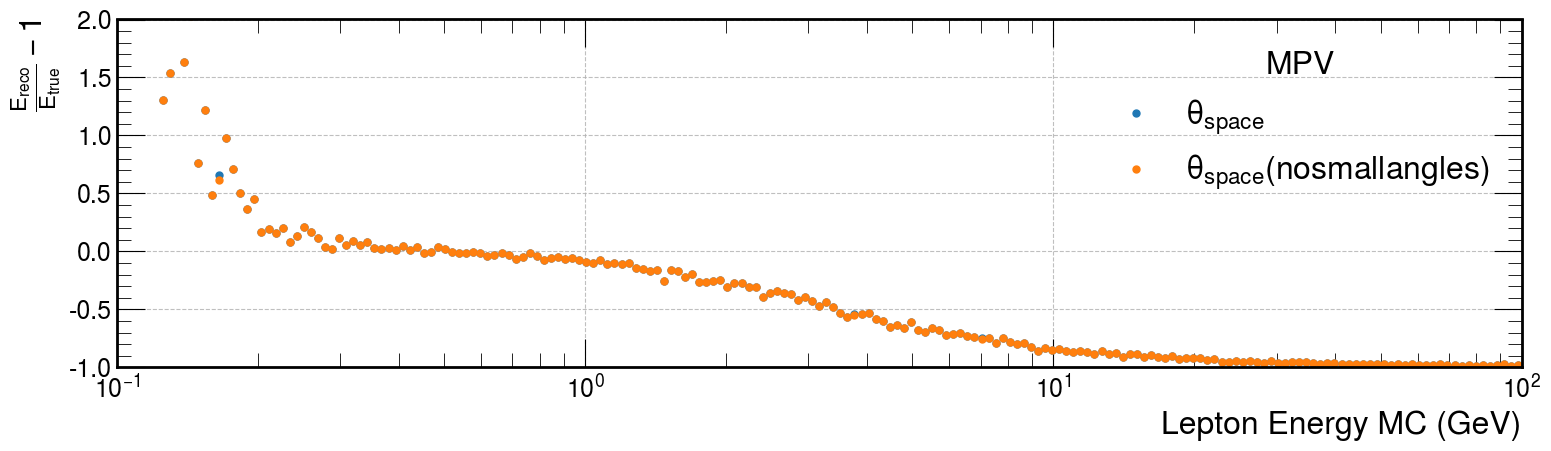

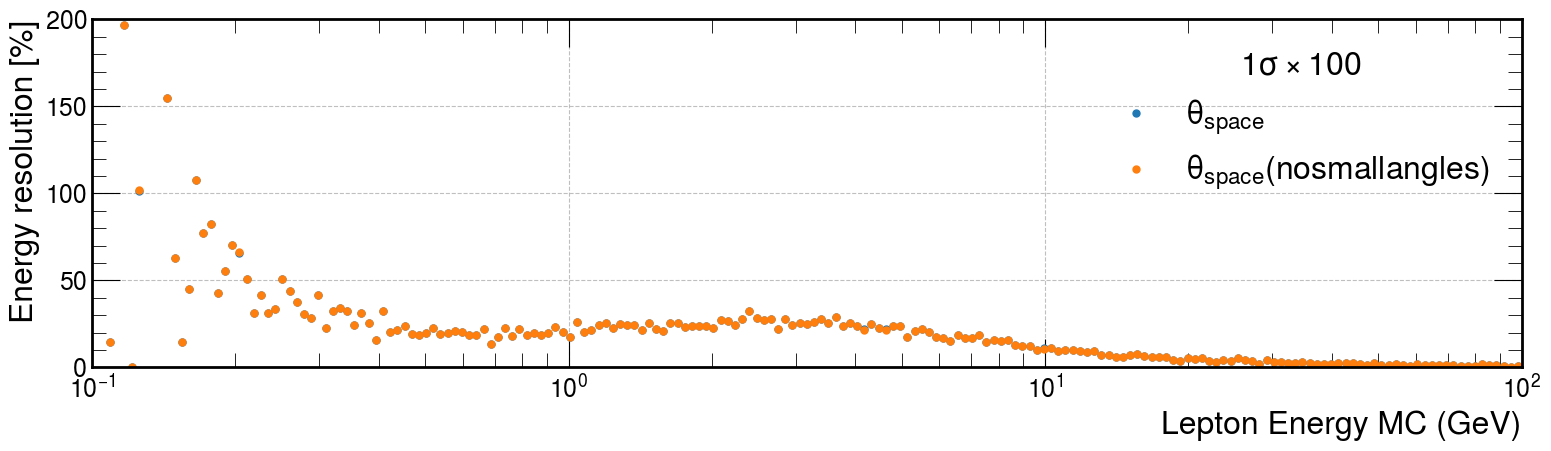

In [480]:
plt.figure(figsize=[16,5])
plot_res_vs_energy(trueE_nosqrt,
                   recoE_nosqrt,
                   infotype='median',
                   label=r'$\theta_{space}$')
plot_res_vs_energy(trueE_nosqrt_skip,
                   recoE_nosqrt_skip,
                   infotype='median',
                   label=r'$\theta_{space} (no small angles)$')
plt.xlabel('Lepton Energy MC (GeV)', fontsize=23)
plt.ylim(-1,2)

plt.figure(figsize=[16,5])
plot_res_vs_energy(trueE_nosqrt,
                   recoE_nosqrt,
                   label=r'$\theta_{space}$')
plot_res_vs_energy(trueE_nosqrt_skip,
                   recoE_nosqrt_skip,
                   label=r'$\theta_{space} (no small angles)$')
plt.xlabel('Lepton Energy MC (GeV)', fontsize=23)
plt.ylim(0,200)
